<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Build-a-Convolutional-Neural-Network-(CNN)" data-toc-modified-id="Build-a-Convolutional-Neural-Network-(CNN)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build a Convolutional Neural Network (CNN)</a></span></li><li><span><a href="#Testing-the-model-before-we-train-it" data-toc-modified-id="Testing-the-model-before-we-train-it-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing the model before we train it</a></span></li><li><span><a href="#Training-the-CNN" data-toc-modified-id="Training-the-CNN-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training the CNN</a></span></li><li><span><a href="#Testing-the-model-after-we-have-trained-it" data-toc-modified-id="Testing-the-model-after-we-have-trained-it-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Testing the model after we have trained it</a></span></li></ul></div>

# Introduction

The goal of this notebook is to show you how to build a simple Convolutional Neural Network (CNN) for classification in Keras.

For this, first we need data! Search for open datasets of free images that show cars and bikes. E.g., Google has published the Open Image Dataset V4:

https://storage.googleapis.com/openimages/web/visualizer/index.htm

Prepare a folder data with the following structure:

    data
        train
            car
            bike
        test
            car
            bike
            
and store at least some
- hundreds-1000 of images for each object category in the training subfolders
- some hundreds of images for each object category in the test subfolders


# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib
import matplotlib.pyplot as plt

print( "Your NumPy version is:      " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is:      " + keras.__version__ )
print( "Your OpenCV version is:     " + cv2.__version__ )
print( "Your Matplotlib version is: " + matplotlib.__version__)

Using TensorFlow backend.


Your NumPy version is:      1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is:      2.2.4
Your OpenCV version is:     4.1.0
Your Matplotlib version is: 2.0.2


# Prepare an image provider class

We define a class ``image_provider`` that will give us a convenient access to the images.

Given a root folder (e.g. "C:\\data"), it automatically determines which subfolders are there (e.g. "C:\\data\\car" and "C:\\data\\bike"). Each subfolder is assumed to be one of the categories we are interested in (e.g. "car" and "bike").

An image provide object then stores a list of all training items:
    
        [filename1, class_id, class_name, teacher_vec]
        [filename2, class_id, class_name, teacher_vec]
        ...

In [2]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (100,100)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_training_items = []
       
        self.class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder\n\t", root_folder,
              "\nI found the following subfolders/classes:")
        print(self.class_names)
        
        self.nr_classes = len(self.class_names)
        
        # For each subfolder ...
        for class_id, class_name in enumerate(self.class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name)
                 if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames),
                                                    subfolder_name) )
            
            # For each image filename in current subfolder ...
            for filename in filenames:
                
                teacher_vec = np.zeros( self.nr_classes )
                teacher_vec[class_id] = 1.0
                
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available.".format(self.nr_images))
        
        print("Here are the first 3 entries of the training items list generated:")
        print(self.all_training_items[:3])
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.get_specific_image( rnd_idx )

Let's test the image provider class:

In [3]:
train_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train"
train_img_provider = image_provider( train_folder )

Under folder
	 V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train 
I found the following subfolders/classes:
['bikes', 'cars']
1000 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train/bikes/
1000 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train/cars/
There are 2000 images in total available.
Here are the first 3 entries of the training items list generated:
[['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0001.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0002.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0003.JPEG', 0, 'bikes', array([1., 0.])]]


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (100, 100, 3)
teacher vec: [0. 1.]


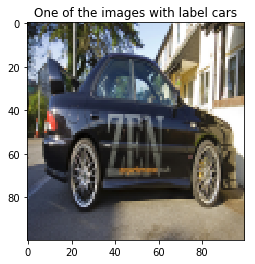

In [4]:
image, class_id, class_name, teacher_vec = \
    train_img_provider.get_random_image()
    
THE_INPUT_IMG_SHAPE = image.shape
    
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(class_name))
plt.show()

# Build a Convolutional Neural Network (CNN)

Now we define a simple CNN in Keras.

What we need to specify is the input shape of a single image:

    (image_height, image_width, nr_color_channels)
    
Further, we need to specify how many output neurons the CNN shall have. This corresponds to the number of object classes we want to discriminate (classifiy) with the CNN:

    e.g., nr_output_neurons = 2 ("car" vs. "bike")
    e.g., nr_output_neurons = 3 ("car" vs. "bike" vs. "truck")
    
And then there are a lot of "hyperparameters" (model parameters we have to set manually):

- how many conv layers?
- how many pooling layers?
- order of layers?
- for each conv layer:
  - nr of filters?
  - kernel side length?
  - kernel stride?
  - activation function to use?
- for each max-pooling layer:
  - kernel side length?
  - kernel stride?
- for the final MLP at the end:
  - nr of layers?
  - for each MLP layer:
    - nr of neurons?
    - activation function to use?

In [5]:
from keras.utils import to_categorical
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras import backend as K

def build_cnn_model(input_shape_of_single_image, nr_output_neurons):
    
    
    # clear the last Keras session
    # this will clear the underlying TensorFlow graph
    K.clear_session()

    model = Sequential()

    # 1. Define the feature hierarchy:
    
    # Layer 1
    nr_filter       = 32
    kernel_side_len = 4
    kernel_stride   = 2
    model.add(Conv2D(nr_filter,
                     kernel_size=(kernel_side_len, kernel_side_len),
                     strides=(kernel_stride, kernel_stride),
                     activation='relu',
                     input_shape=input_shape_of_single_image)
             )
    
    # Layer 2
    kernel_side_len = 2
    kernel_stride   = 2
    model.add(MaxPooling2D(pool_size=(kernel_side_len, kernel_side_len),
                           strides=(kernel_stride, kernel_stride))
             )

    # 2. Define the MLP part:
    model.add(Flatten())
    model.add(Dense(nr_output_neurons, activation='softmax'))
    
    
    # 3. Show the model
    model.summary()


    # 4. Build model and configure model for training
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model

# end build_a_cnn_model


# create a CNN model
my_cnn = build_cnn_model(THE_INPUT_IMG_SHAPE,
                         train_img_provider.nr_classes)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36866     
Total params: 38,434
Trainable params: 38,434
Non-trainable params: 0
_________________________________________________________________


# Testing the model before we train it

Here we define a simple test function for a CNN. It takes the CNN model and a test image provider and returns the correct classification rate.

If we did not train so model so far, all the weights were initialized just randomly. For this, the correct classification rate should be somewhere around 0.5 (random guessing rate) for a two class classification problem.

In [6]:
def test_cnn(your_cnn,
             test_img_provider,
             show_example_predictions):
    
    nr_test_images = test_img_provider.nr_images
    
    correct_classified = 0
    
    print("I will test the CNN on {} test images".
          format(nr_test_images))
    
    for test_img_nr in range(0, nr_test_images):
        
        if test_img_nr % 100 == 0:
            print("Tested {} images so far".
                  format(test_img_nr))
        
        # 1. 
        # get the next test image from the
        # test image provider
        img, gt_class_nr, class_label, teacher_vec = \
            test_img_provider.get_specific_image( test_img_nr )
    
        
        # 2.
        # reshape image (3D array) to a 4D array
        # since Keras wants 4D arrays as input
        X = img.reshape((-1,
                         img.shape[0],
                         img.shape[1],
                         img.shape[2]
                        )
                       )
        
        # 3.
        # let the CNN predict the image class
        neuron_outputs = your_cnn.predict(X)
        
        # 4.
        # determine the predicted class nr
        predicted_class_nr = np.argmax(neuron_outputs.reshape(-1))
        
        # 5.
        # Did the CNN correctly predict the class?
        if predicted_class_nr == gt_class_nr:
            correct_classified +=1
        prediced_class_label = \
            test_img_provider.class_names[predicted_class_nr]
            
        # 6.
        # Show image, predicted class and gt class?
        if show_example_predictions and np.random.randint(50)==0:
                        
            plt.title("Is: {} vs. Predicted: {}\nNeuron out: {}"
                      .format(class_label,
                              prediced_class_label,
                              neuron_outputs
                             )
                     )
            plt.imshow( img )
            plt.show()
            
        
    # finally, compute the correct classification rate
    corr_classification_rate = \
        float(correct_classified) / float(nr_test_images)
        
    print("Correctly classified: {} of {} images:"
          " --> rate: {:.2f}"
          .format(correct_classified,
                  nr_test_images,
                  corr_classification_rate)
         )   
    
    # return the correct classification rate
    return corr_classification_rate
    
    

Now let us test how good our model performs on the test data!

In [7]:
test_folder = "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\test"
test_img_provider = image_provider( test_folder )

show_example_predictions = False
corr_class_rate = test_cnn(my_cnn,
                           test_img_provider,
                           show_example_predictions)

Under folder
	 V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\test 
I found the following subfolders/classes:
['bikes', 'cars']
344 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\test/bikes/
307 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\test/cars/
There are 651 images in total available.
Here are the first 3 entries of the training items list generated:
[['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\test/bikes/1001.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\test/bikes/1002.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\test/bikes/1003.JPEG', 0, 'bikes', array([1., 0.])]]
I will test the CNN on 651 test images
Tested 0 images so far
Tested 100 images so far
Tested 200 images so far
Tested 300 images so far
Tested 400 images so far
Tested 500 images so far
Tested 600 images so far
Correctly classified: 338 of 651 images: --> rate: 0.52


# Training the CNN

Now we will train the CNN. We will use "Stochastic Gradient Descent" (SGD) with just one training image per training step for the sake of simplicity (corresponds to mini batch with batch size 1). 

But note, that training could also be done using the "mini batch" approach. This means that in each training step we approximate the gradient for gradient descent step using e.g. 16,32,or 64 images.

This is normally much faster, however, it also means that we have to put all the images in one large 4D training array (img_nr, img_height, img_width, nr_channels). And this can make problems when we have a large dataset due to out-of-memory errors on the GPU or CPU being used.

In [8]:
import time

def train_cnn(your_cnn, train_img_provider, nr_train_steps):
    
    train_time_start = time.time()
    print("Training start time: ", train_time_start)
    
    height      = THE_INPUT_IMG_SHAPE[0]
    width       = THE_INPUT_IMG_SHAPE[1]
    nr_channels = THE_INPUT_IMG_SHAPE[2]

    X = np.zeros( (1,height,width,nr_channels)     )
    Y = np.zeros( (1,train_img_provider.nr_classes) )

    print("Steps to train: {}".format(nr_train_steps))
    
    for train_step in range(0,nr_train_steps):

        if train_step % 500 == 0:
            print("training step ", train_step)

        # 1. get the next random image from the dataset
        image, class_id, class_name, teacher_vec = \
            train_img_provider.get_random_image()

        # 2. put the image into a 4D array
        #    note: Keras expects a 4D array as input for
        #          the training function fit()
        X[0,:,:,:] = image

        # 3. the teacher value array expected by Keras
        #    is a 2D array
        Y[0,:] = teacher_vec


        # 3. train the model using this image    
        my_cnn.fit(X,Y,verbose=0)        
        
    print("Training finished!")
    
    train_time_end = time.time()
    print("Training end time: ", train_time_end)
        
    train_duration_sec = train_time_end - train_time_start
    print("Training time: {:.2f} sec = {:.2f} min"
          .format(train_duration_sec,
                  train_duration_sec/60)
          )
                  
train_cnn(my_cnn, train_img_provider, 5000)

Training start time:  1555076632.0465503
Steps to train: 5000
training step  0
Instructions for updating:
Use tf.cast instead.
training step  500
training step  1000
training step  1500
training step  2000
training step  2500
training step  3000
training step  3500
training step  4000
training step  4500
Training finished!
Training end time:  1555076675.6805353
Training time: 43.63 sec = 0.73 min


# Testing the model after we have trained it

Now let us see how good the correct classification rate is after adapting all the weights!

If we really learned something, the correct classification rate should now be much larger than 0.5!

In [9]:
show_example_predictions = False
corr_class_rate = test_cnn(my_cnn,
                           test_img_provider,
                           show_example_predictions)

I will test the CNN on 651 test images
Tested 0 images so far
Tested 100 images so far
Tested 200 images so far
Tested 300 images so far
Tested 400 images so far
Tested 500 images so far
Tested 600 images so far
Correctly classified: 540 of 651 images: --> rate: 0.83
